In [13]:
%pip install openai googlesearch-python beautifulsoup4 scipy pandas matplotlib
from openai import OpenAI
from googlesearch import search
import re
import requests
from bs4 import BeautifulSoup
from scipy.spatial import distance
import pandas as pd
import logging
import matplotlib.pyplot as plt

logger = logging.Logger("researcher")

# HOSTING & MODEL CONFIG
HOST = "http://localhost:1234/v1" # LM Studio
# HOST = "https://api.openai.com/v1" # OpenAI API
# HOST = "http://localhost:11434/v1" # Ollama
MODEL = "llama-3.2-3b-instruct" # LLM Model
EMBEDDING_MODEL = "text-embedding-all-minilm-l6-v2-embedding" # Embedding Model
KEY = "ollama" # API Key

# SEARCH CONFIG
# Number of sites to visit is RESEARCH_LEN * TOPIC_DEPTH so 5 searches and 5 sites per search = 25 sites overall
RESEARCH_LEN = 10 # Number of (search engine) searches to perform
TOPIC_DEPTH = 5 # How many levels of depth to search for a topic or number of sites to scrape

# RAG CONFIG
# (CHUNK_SIZE + OVERLAP) * RAG_RETRIEVAL_AMT = roughly the number of tokens used for context. Adjust based on model token limit.
CHUNK_SIZE = 100 # Chunk size for the model
OVERLAP = 10 # Overlap between chunks
RAG_RETRIEVAL_AMT = 40 # Number of chunks to retrieve for RAG.

  Using cached openai-1.61.1-py3-none-any.whl.metadata (27 kB)
  Using cached googlesearch_python-1.3.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached beautifulsoup4-4.13.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached scipy-1.15.1-cp311-cp311-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached pandas-2.2.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached matplotlib-3.10.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached anyio-4.8.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached jiter-0.8.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached soupsieve

In [8]:
class Source():
    def __init__(self, url, text):
        self.url = url
        self.text = text

    def __str__(self):
        return f"<source url=\"{self.url}\"> {self.text} </source>"
    
    def __repr__(self):
        return self.__str__()

In [9]:
class Browser():
    '''
    A class to search for and scrape text from the web
    '''
    def __init__(self):
        # Preprocessing steps to be applied to the raw text
        # Get only the text from the html
        self.preprocessing = [
            lambda x: BeautifulSoup(x, 'html.parser').get_text(),
            # Force unicode
            lambda x: x.encode('ascii', 'ignore').decode('ascii'),
            # Remove extra whitespace
            lambda x: re.sub(r'\s+', ' ', x),
            # Remove extra newlines
            lambda x: re.sub(r'\n+', '\n', x),
            # Remove leading and trailing whitespace
            lambda x: x.strip()
        ]

    def scrape(self, url):
        '''
        Scrape the text from the given URL and preprocess it
        '''
        try:
            raw_text = requests.get(url).text
        except:
            return ""
        steps = [raw_text]
        for process in self.preprocessing:
            steps.append(process(steps[-1]))
        if len(steps[-1]) < 100:
            return ""
        return steps[-1]

In [10]:
class ExtOpenAI(OpenAI):
    '''
    Extends the OpenAI class to include additional functionality for research.
    '''
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.browser = Browser()
        self.history = set()
        self.data_store = pd.DataFrame(columns=["text", "url", "embedding"])

    def get_embedding(self, text: str) -> list[float]:
        '''
        Shorthand for geting the embedding for the given text
        '''
        return self.embeddings.create(input=text, model=EMBEDDING_MODEL).data[0].embedding

    def add_source(self, source: Source) -> None:
        '''
        Add data to the data store
        '''
        text = source.text
        url = source.url
        logger.info(f"Adding to data store: {text}")
        embedding = self.get_embedding(text)
        self.data_store.loc[-1] = [text, url, embedding]
        self.data_store.index += 1
        self.data_store = self.data_store.sort_index()

    def top_k_sources(self, query: str, k: int) -> list[Source]:
        '''
        Return the top k cosine similarities from the data store
        '''
        query_embedding = self.get_embedding(query)
        self.data_store["similarity"] = self.data_store["embedding"].apply(lambda x: 1 - distance.cosine(x, query_embedding))
        self.data_store = self.data_store.sort_values("similarity", ascending=False)
        return [Source(row["url"], row["text"]) for _, row in self.data_store.head(k).iterrows()]

    def visualized_sources(self) -> None:
        '''
        Visualize the data store
        '''
        plt.scatter(self.data_store["embedding"].apply(lambda x: x[0]), self.data_store["embedding"].apply(lambda x: x[1]))
        plt.show()

    def topic_research(self, query, num=3) -> None:
        '''
        Performs research based on a specific question.
        '''
        logger.info(f"Searching for {query}")
        try_count = 0
        while try_count < 3:
            try:
                leads = search(query, num_results=num)
                break
            except:
                try_count += 1
        else:
            logger.error(f"Failed to search for {query}")
            return
        for lead in leads:
            if lead in self.history:
                continue
            self.history.add(lead)
            text = self.browser.scrape(lead)
            # Skip if the text is too short or too long
            if len(text) < 100 or len(text) > 1000000:
                continue
            # If repeating a character more than 10 times, skip
            if re.search(r'(.)\1{10,}', text):
                continue
            blocked = [
                "access denied",
                "denied access",
                "unauthorized",
                "forbidden",
                "error",
                "404",
                "403",
            ]
            if any([block in text.lower() for block in blocked]):
                continue
            # Split text
            text = text.split()

            for i in range(0, len(text), CHUNK_SIZE - OVERLAP):
                chunk = " ".join(text[i:i+CHUNK_SIZE])
                if len(chunk) > 750: # Skip if the chunk is too long
                    continue
                self.add_source(Source(lead, chunk))

    def breadth_research(self, query) -> list[Source]:
        '''
        It will initialize research on a specific question, then tries to find a new lead based off what hasn't been answered yet.
        '''
        existing_prompts = set()
        while len(existing_prompts) < RESEARCH_LEN:
            new_leads_prompt = f"""
            Make a new and concise search engine query based on this prompt that has not yet been asked and do not elaborate: {query}.
            Existing queries: {existing_prompts}
            """
            leads_query = self.chat.completions.create(
                model=MODEL,
                messages=[
                    {"role": "system", "content": new_leads_prompt},
                ]
            ).choices[0].message.content
            
            if leads_query in existing_prompts:
                continue
            existing_prompts.add(leads_query)
            
            self.topic_research(leads_query, TOPIC_DEPTH)

        return self.top_k_sources(query, RAG_RETRIEVAL_AMT)
    
    def handle_stream(self, stream):
        '''
        Print the stream of sources
        '''
        content_text = ""
        try:
            for chunk in stream:
                chunk_text = chunk.choices[0].delta.content
                if chunk_text == None:
                    chunk_text = ""
                content_text += chunk_text
                print(chunk_text, end="")
        except Exception as e:
            logger.error(f"Failed to print stream: {e}")
        return content_text

In [11]:
client = ExtOpenAI(
    base_url=HOST,
    api_key=KEY
)


# RESEARCH

<source url="https://ilab.academy/en/romance-languages/"> the subsequent fragmentation of its territories, isolated communities began to develop their distinct linguistic features, leading to a divergence from the original Latin and from each other. This process of differentiation gave rise to the Romance languages we recognize today. Understanding the Romance languages entails recognizing their shared grammatical structures, vocabulary, and phonological attributes. These similarities are a testament to their common origin, allowing for a degree of mutual intelligibility among speakers of different Romance languages. At the same time, each language has embraced unique elements, influenced by regional histories, cultures, and interactions with other language groups. In the present </source>
<source url="https://en.wikipedia.org/wiki/Romance_linguistics"> Languages. Cambridge: Cambridge University Press. Gerhard Ernst et al., eds. Romanische Sprachgeschichte: Ein internation

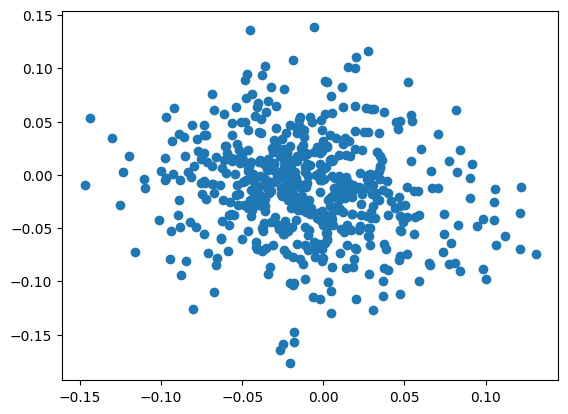


# THOUGHTS

After considering the given information, I'll create a thought-provoking response.

To answer how the Romance languages diverged over time and what types of changes occurred in each of these offshoot languages, let's dive into the complexities of language evolution.

As we know, the Romance languages originated from Vulgar Latin, which was spoken by the Roman Empire. The fragmentation of the Roman Empire, starting around the 5th century A.D., led to the divergence of Vulgar Latin into proto-Romance dialects.

Isolation, geographical and sociopolitical changes, invasions, and cultural interactions all contributed to the development of distinct linguistic features in each Romance language. For example, French has a more complex grammatical system due to its use of tenses and conjugations. Portuguese retains many original Latin sounds, making it phonetically consistent.

Other notable differences include vocabulary additions from invading peoples and geographic isolation. For

In [12]:

query = input("Enter your query: ")

print("\n# RESEARCH\n")

# Research

research = client.breadth_research(query)

raw_research_text = "\n".join([source.text for source in research])
raw_research_text_link = "\n".join([str(source) for source in research])

print(raw_research_text_link)

client.visualized_sources()

# Thoughts
print("\n# THOUGHTS\n")

thoughts_prompt = f"You are a researcher answering \"{query}\". Speak to yourself about your thought process given the following information. Research: {raw_research_text}"

# Get the thoughts
thoughts_stream = client.chat.completions.create(model=MODEL, messages=[{"role": "user", "content": thoughts_prompt}], stream=True)
thoughts_text = client.handle_stream(thoughts_stream)

print("\n# Output\n")

# Submit final generation
content_prompt = f"""
Answer \"{query}\". Simplify and clarify your thought process into a coherent answer. Make examples and elaborate how it is applicable. Utilize provided sources and note down from where. Output in markdown. End with sources section at the end with links.:
<thoughts>
    {thoughts_text}
</thoughts>
<sources>
    {raw_research_text_link}
</sources>
"""

# Get final generation
content_stream = client.chat.completions.create(model=MODEL, messages=[{"role": "user", "content": content_prompt}], stream=True)
content_text = client.handle_stream(content_stream)


print("\n# Complete\n")

# # Print the output
# # Full output
# print(f"""
# <query>{query}</query>
# <thoughts>{thoughts_text}:</thoughts>
# <response>{content_text}</response>
# <sources>{raw_research_text_link}
# </sources>
# """)